In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyMELTScalc as M
import sys
sys.path.append(r"H:/My Drive/2022/Github/pyMELTScalc/MELTS")

# Decompression and degassing behaviour of basaltic magmas

This notebook will take you through some simple calculations used to simulate the degassing behaviour of basaltic melts during ascent towards the surface. Take a minute or two to discuss why this information might be useful...

For these calculations we'll be using a erupted melt composition from Volcan Wolf in the Galapagos Archipelago (Stock et al. 2018; https://doi.org/10.1029/2018GC007936), let's start by loading that in as a dictionary (those who did the thermobarometry tutorial will notice I use the same naming convention as in Thermobar):

In [2]:
starting_comp = {'SiO2_Liq': 48.82,
                 'TiO2_Liq': 3.55,
                 'Al2O3_Liq': 13.62,
                 'FeOt_Liq': 12.19,
                 'MnO_Liq': 0.22,
                 'MgO_Liq': 5.54,
                 'CaO_Liq': 9.90,
                 'Na2O_Liq': 3.40,
                 'K2O_Liq': 0.67,
                 'P2O5_Liq': 0.47}

Independent analyses of submarine glasses from the surrounding Galapagos platform indicate that the Wolf magmas contain ~1 wt% H$_2$O prior to eruption (Peterson et al. 2017). In addition, OPAM and Cpx-Liq barometry indicate that magma is stored in the lower crust at ~ 3kbar (Stock et al. 2018). The first thing we can do is use the latest rhyolite-MELTS model (v1.2.0), which contains a mixed H$_2$O-CO$_2$ fluid model, to determine the maximum amount of CO$_2$ that could dissolve in this magma at the pressure indicated by mineral and melt barometry.

Examine the results. 

- **What is the solubility of CO$_2$ in this magma with 1 wt% H$_2$O? How does this change if you lower or rise the melt H$_2$O content?**

In [3]:
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

In [5]:
T_Liq, H2O, CO2 = M.findCO2_multi(Model = "MELTSv1.2.0",
                                bulk = starting_comp,
                                Fe3Fet_Liq = 0.17,
                                H2O_Liq = 1,
                                P_bar = 3000)

  0%|          | 0/1 [00:00<?, ?it/s]

0.22500000000000003

In [6]:
CO2

0.22500000000000003

- **Using the results from that calculation (i.e., the liquidus temperature and the melt CO$_2$ content), use the following code to simulate isothermal decompression of this magma as it ascends towards the surface during an eruption**

In [7]:
Decompression_const_T = M.isothermal_decompression(Model = "MELTSv1.2.0",
                                                   bulk = starting_comp,
                                                   T_C = T_Liq,
                                                   P_start_bar = 3000,
                                                   P_end_bar = 50,
                                                   dp_bar = 25,
                                                   Fe3Fet_Liq = 0.17,
                                                   H2O_Liq = H2O,
                                                   CO2_Liq = CO2)

Plot up the results and try to answer the following questions:

 - **What is the H$_2$O content of the melt phase at 500 bars (50 MPa)?**
 - **At what pressure is the fluid volume fraction greater than 0.4 (i.e., 40%)?**
 - **At what pressure does the melt become 'water saturated'?**
 
 **If you're waiting for others to finish, think about the following questions**
 - **This initial model represents closed system degassing (melt and fluid remain in equilibrium during decompression), if we add a command 'Frac_fluid = True' to the function above, we can instead simulate open system degassing (fluid separates from the melt as it forms). Try implementing this change and consider the same questions.**
 - **What problems might be associated with the isothermal assumption used in this calculation? What other constraints could we impose on the thermal properties of the decompressing magma?**          

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


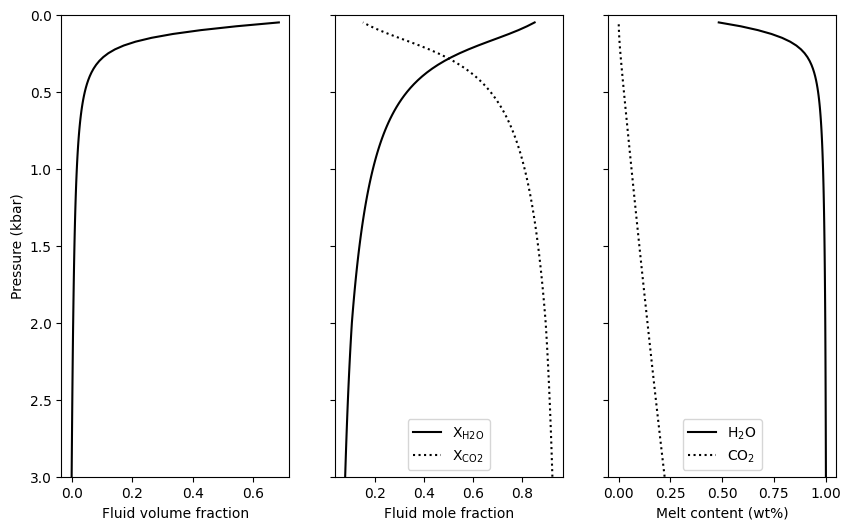

In [5]:
f, a = plt.subplots(1,3, figsize = (10,6), sharey = True)
a[0].plot(Decompression_const_T['Volume']['fluid1']/Decompression_const_T['Volume'].sum(axis = 1),
         Decompression_const_T['All']['P_bar']/1000, '-k')
a[0].set_ylim([3,0])
a[0].set_ylabel('Pressure (kbar)')
a[0].set_xlabel('Fluid volume fraction')

xH2O = (Decompression_const_T['fluid1']['H2O_fluid1']/18)/(Decompression_const_T['fluid1']['H2O_fluid1']/18 + 
                                                           Decompression_const_T['fluid1']['CO2_fluid1']/44)

a[1].plot(xH2O, Decompression_const_T['All']['P_bar']/1000, '-k', label = "X$_{H2O}$")
a[1].plot(1-xH2O, Decompression_const_T['All']['P_bar']/1000, ':k', label = "X$_{CO2}$")
a[1].set_ylim([3,0])
a[1].set_xlabel('Fluid mole fraction')
a[1].legend()

a[2].plot(Decompression_const_T['All']['H2O_Liq'], 
          Decompression_const_T['All']['P_bar']/1000, '-k', label = "H$_2$O")
a[2].plot(Decompression_const_T['All']['CO2_Liq'], 
          Decompression_const_T['All']['P_bar']/1000, 
          ':k', label = "CO$_2$")
a[2].set_ylim([3,0])
a[2].set_xlabel('Melt content (wt%)')
a[2].legend()

Instead of holding the temeprature of the system constant, we could hold the entropy constant (isentropic). Using the following code we can simulate adiabatic ascent of magma towards the surface.

- **What happens to the temperature of the melt phase during adiabatic decompression?**
- **Try rerunning these models with a higher water content (~2 - 3 wt%). What happens to the temperature of the system at low pressure? What is causing this?**

In [6]:
Decompression_const_S = M.isentropic_decompression(Model = "MELTSv1.2.0",
                                                   bulk = starting_comp,
                                                   T_C = T_Liq,
                                                   P_start_bar = 3000,
                                                   P_end_bar = 50,
                                                   dp_bar = 25,
                                                   Fe3Fet_Liq = 0.17,
                                                   H2O_Liq = H2O,
                                                   CO2_Liq = CO2)

Running MELTSv1.2.0 calculation... Complete (time taken = 67.86 seconds)

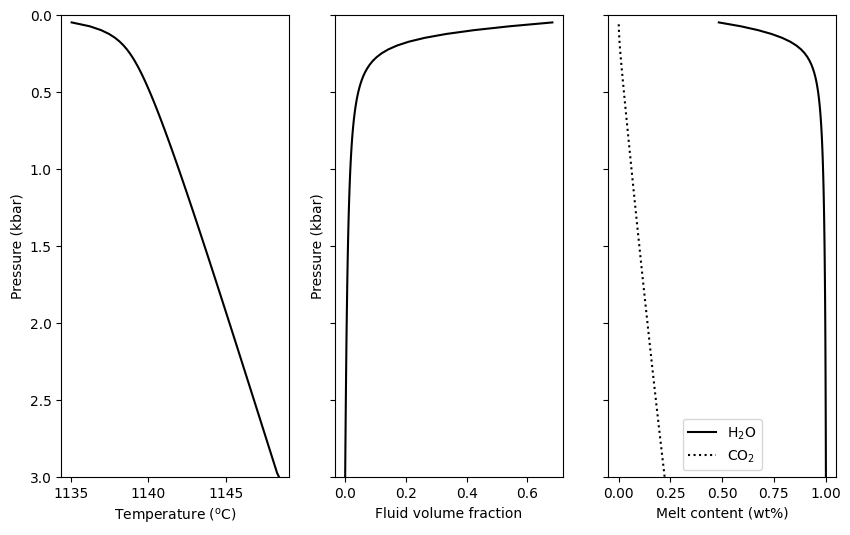

In [7]:
f, a = plt.subplots(1,3, figsize = (10,6), sharey = True)
a[0].plot(Decompression_const_S['All']['T_C'],
         Decompression_const_S['All']['P_bar']/1000, '-k')
a[0].set_ylim([3,0])
a[0].set_ylabel('Pressure (kbar)')
a[0].set_xlabel('Temperature ($^o$C)')

a[1].plot(Decompression_const_S['Volume']['fluid1']/Decompression_const_S['Volume'].sum(axis = 1),
         Decompression_const_S['All']['P_bar']/1000, '-k')
a[1].set_ylim([3,0])
a[1].set_ylabel('Pressure (kbar)')
a[1].set_xlabel('Fluid volume fraction')


a[2].plot(Decompression_const_S['All']['H2O_Liq'], 
          Decompression_const_S['All']['P_bar']/1000, '-k', label = "H$_2$O")
a[2].plot(Decompression_const_S['All']['CO2_Liq'], 
          Decompression_const_S['All']['P_bar']/1000, 
          ':k', label = "CO$_2$")
a[2].set_ylim([3,0])
a[2].set_xlabel('Melt content (wt%)')
a[2].legend()